**Associated Data Files:** 
1. `transactions.csv` Each row denotes a transaction. The columns are as follows:

* TRANSACTION_ID: A unique id of the credit card transaction
* TX_DATETIME: Date time of the transaction
* CUSTOMER_ID: Id of the credit card owner
* TERMINAL_ID: Id of the terminal where transaction originated
* TX_AMOUNT: Amount of the transaction in dollars
* TX_FRAUD: Label denoting if the transaction was fraudulent (label of 1) or genuine (label of 0)

2. `card_data.csv`. Each row denotes a transaction. This file contains pre-computed feature engineered columns (in addition to the ones listed above). The extra columns are as follows:

* IS_WEEKEND: Denotes if the transaction occurred over a weekend (label of 1) or a weekday (label of 0)
* IS_WEDNESDAY: Denotes if the transaction occurred on Wednesday
* IS_NIGHT: Denotes if the transaction occurred in the night (label of 1) or during a day (label of 0) 
* TX_HOUR: The hour at which the transaction occurred
* TX_DATE: The date of the transaction (i.e., the date excluding the time information)
* TX_WEEK: The week of the transaction (i.e., the week number when the transaction occurred)
* TERMINAL_TOTAL_1D: The number of transactions that occurred in the previous *day* for the associated terminal id
* TERMINAL_FRAUD_1D: The number of fraudulent transactions that occurred in the previous *day* for the associated terminal id
* TERMINAL_RISK_1D: The ratio of fraudulent transactions that occurred in the previous *day* for the associated terminal id
* CUSTOMER_TOTAL_1D: The number of transactions that occurred in the previous *day* for the associated customer id
* CUSTOMER_FRAUD_1D: The number of fraudulent transactions that occurred in the previous *day* for the associated customer id
* CUSTOMER_RISK_1D: The ratio of fraudulent transactions that occurred in the previous *day* for the associated customer id
* TERMINAL_TOTAL_1W: The number of transactions that occurred in the previous *week* for the associated terminal id
* TERMINAL_FRAUD_1W: The ratio of fraudulent transactions that occurred in the previous *week* for the associated terminal id
* TERMINAL_RISK_1W: The ratio of fraudulent transactions that occurred in the previous *week* for the associated terminal id
* CUSTOMER_TOTAL_1W: The number of transactions that occurred in the previous *week* for the associated customer id 	
* CUSTOMER_FRAUD_1W: The number of fraudulent transactions that occurred in the previous *week* for the associated customer id
* CUSTOMER_RISK_1W: The ratio of fraudulent transactions that occurred in the previous *week* for the associated customer id	
* SPENT_1D: The average spent for the customer in the previous *day*	
* SPENT_1W: The average spent for the customer in the previous *week*	

In [28]:
# Import the numpy and pandas library
import numpy as np
import pandas as pd

# for date time
from datetime import datetime

# Import the matplotlib library, used for plotting
import matplotlib.pyplot as plt
import seaborn as sns 

# for stats and ML
from finml import *
import statsmodels.api as sm
from sklearn import metrics
from sklearn.metrics import roc_auc_score

# disable messages to increase output readability
import warnings
import tensorflow as tf
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow import random as tf_random
from tensorflow.keras.backend import clear_session
warnings.simplefilter(action='ignore', category=FutureWarning)
tf.get_logger().setLevel('ERROR')

In [2]:
def set_seeds(seed=123):
    import os, random
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

In [3]:
df_transactions = pd.read_csv("./transactions.csv", index_col="TRANSACTION_ID", parse_dates=["TX_DATETIME"])
df_transactions.head()

,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD
TRANSACTION_ID,,,,,
730399,2024-03-02 16:58:04,1610,7393,122.82,0
718607,2024-03-02 03:54:17,1610,3193,96.39,0
732845,2024-03-02 22:20:50,1610,2239,167.10,0
726608,2024-03-02 12:59:55,1610,9572,121.51,0
729587,2024-03-02 15:54:29,1610,9850,191.29,0


In [4]:
# training set: all data till 2024-03-6 (inclusive) 
# test set: transactions that happened on 2024-03-10
tr_end_date = datetime(2024, 3, 6)
te_start_date = datetime(2024, 3, 10)
te_end_date = datetime(2024, 3, 11)

df_train = df_transactions.query(f"TX_DATETIME < @tr_end_date")
df_test = df_transactions.query(f"TX_DATETIME >= @te_start_date and TX_DATETIME <= @te_end_date")

display(df_train)
display(df_test)

,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD
TRANSACTION_ID,,,,,
730399,2024-03-02 16:58:04,1610,7393,122.82,0
718607,2024-03-02 03:54:17,1610,3193,96.39,0
732845,2024-03-02 22:20:50,1610,2239,167.10,0
726608,2024-03-02 12:59:55,1610,9572,121.51,0
729587,2024-03-02 15:54:29,1610,9850,191.29,0
...,...,...,...,...,...
762836,2024-03-05 12:26:14,4017,3597,129.29,0
764437,2024-03-05 14:45:06,4131,9062,108.93,0
761758,2024-03-05 10:59:13,2564,5815,59.30,0


,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD
TRANSACTION_ID,,,,,
817701,2024-03-10 06:19:07,2626,3942,64.58,0
826437,2024-03-10 15:00:25,2626,2053,119.51,0
821282,2024-03-10 10:16:28,2626,1343,63.52,0
819760,2024-03-10 08:48:13,2932,3196,46.75,0
822330,2024-03-10 11:12:57,2932,3196,95.37,0
...,...,...,...,...,...
823988,2024-03-10 12:42:10,1860,9340,26.63,0
816377,2024-03-10 03:59:33,2818,7914,148.73,0
818143,2024-03-10 06:58:10,2691,9851,124.91,0


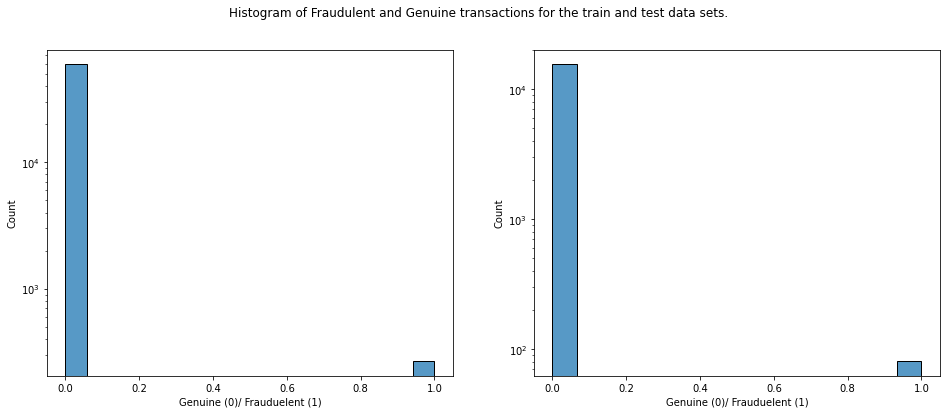

In [6]:
# histogram of fraudulent and genuine transactions for the training and test datasets
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=False, sharex=True, figsize=(16,6))

# title
fig.suptitle("Histogram of Fraudulent and Genuine transactions for the train and test data sets.");

sns.histplot(x="TX_FRAUD", data=df_train, label="Price", ax=ax1)
sns.histplot(x="TX_FRAUD", data=df_test, label="Volume", ax=ax2);

# set log scale
ax1.set_yscale('log')
ax2.set_yscale('log')

# set xlabel
xlabel = "Genuine (0)/ Frauduelent (1)"
ax1.set_xlabel(xlabel);
ax2.set_xlabel(xlabel);

**LOGISTIC MODEL**

In [7]:
df_train["constant"] = 1
df_test["constant"] = 1
input_features = ["constant", "TX_AMOUNT"]
output_feature = "TX_FRAUD"

logit_1 = sm.Logit(df_train[output_feature], df_train[input_features]).fit()
logit_1.summary()

Optimization terminated successfully.
         Current function value: 0.026100
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               TX_FRAUD   No. Observations:                59449
Model:                          Logit   Df Residuals:                    59447
Method:                           MLE   Df Model:                            1
Date:                Wed, 05 Mar 2025   Pseudo R-squ.:                 0.09816
Time:                        17:18:12   Log-Likelihood:                -1551.6
converged:                       True   LL-Null:                       -1720.5
Covariance Type:            nonrobust   LLR p-value:                 1.959e-75
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
constant      -6.4938      0.102    -63.745      0.000      -6.693      -6.294
TX_AMOUNT      0.0062      0.000     17.701      0.000       0.006       0.007
==============================================================================
"""

**NEURAL NETWORK MODEL**

In [8]:
drop_features = ['TX_DATETIME', 'CUSTOMER_ID', 'TERMINAL_ID','TX_FRAUD']
X_train = df_train.drop(columns=drop_features)  
y_train = df_train["TX_FRAUD"]  
X_test = df_test.drop(columns=drop_features)  
y_test = df_test["TX_FRAUD"]  

clear_session()

units = 8
output_units, output_activation = (1, 'sigmoid')

hidden_layer_activation = "ReLU"
input_shape = X_train.shape[1:]
input_layer = Input(shape=input_shape, name="input_layer")

op_1 = Dense(units=units, activation=hidden_layer_activation, name="hidden_layer_1")(input_layer)
op_2 = Dense(units=units, activation=hidden_layer_activation, name="hidden_layer_2")(op_1)
output_layer = Dense(units=output_units, activation=output_activation, name="output_layer")(op_2)

nn_1 = Model(inputs=[input_layer], outputs=[output_layer])
nn_1.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Set training parameters
epochs = 1000
patience = 2
verbose = 2
batch_size = X_train.shape[0]

# Define the early stopping callback
callbacks = [EarlyStopping(monitor='val_loss', patience=patience)]

# Train and validate the model
nn_1.fit(X_train, y_train,
                   epochs=epochs,
                   callbacks=callbacks,
                   validation_data=(X_test, y_test),
                   batch_size=batch_size,
                   verbose=verbose)

Epoch 1/1000
1/1 - 1s - loss: 0.5057 - accuracy: 0.9955 - val_loss: 0.4339 - val_accuracy: 0.9948 - 648ms/epoch - 648ms/step
Epoch 2/1000
1/1 - 0s - loss: 0.4931 - accuracy: 0.9955 - val_loss: 0.4231 - val_accuracy: 0.9948 - 22ms/epoch - 22ms/step
Epoch 3/1000
1/1 - 0s - loss: 0.4807 - accuracy: 0.9955 - val_loss: 0.4123 - val_accuracy: 0.9948 - 20ms/epoch - 20ms/step
Epoch 4/1000
1/1 - 0s - loss: 0.4682 - accuracy: 0.9955 - val_loss: 0.4015 - val_accuracy: 0.9948 - 22ms/epoch - 22ms/step
Epoch 5/1000
1/1 - 0s - loss: 0.4558 - accuracy: 0.9955 - val_loss: 0.3908 - val_accuracy: 0.9948 - 23ms/epoch - 23ms/step
Epoch 6/1000
1/1 - 0s - loss: 0.4435 - accuracy: 0.9955 - val_loss: 0.3801 - val_accuracy: 0.9948 - 23ms/epoch - 23ms/step
Epoch 7/1000
1/1 - 0s - loss: 0.4311 - accuracy: 0.9955 - val_loss: 0.3695 - val_accuracy: 0.9948 - 21ms/epoch - 21ms/step
Epoch 8/1000
1/1 - 0s - loss: 0.4189 - accuracy: 0.9955 - val_loss: 0.3590 - val_accuracy: 0.9948 - 21ms/epoch - 21ms/step
Epoch 9/1000
1

In [10]:
nn_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 2)]               0         
                                                                 
 hidden_layer_1 (Dense)      (None, 8)                 24        
                                                                 
 hidden_layer_2 (Dense)      (None, 8)                 72        
                                                                 
 output_layer (Dense)        (None, 1)                 9         
                                                                 
Total params: 105 (420.00 Byte)
Trainable params: 105 (420.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
# AUC metric for the trained logistic regression model and the trained neural network 
input_features = ["constant", "TX_AMOUNT"]
estimates = logit_1.predict(df_test[input_features])

output_feature = "TX_FRAUD"
logit_1_auc = metrics.roc_auc_score(df_test[output_feature], estimates)

estimates = nn_1.predict(df_test[input_features])
nn_1_auc = metrics.roc_auc_score(df_test[output_feature], estimates)

print(f"logit_1_auc is {logit_1_auc}")
print(f"nn_1_auc is {nn_1_auc}")

486/486 [==============================] - 0s 562us/step
logit_1_auc is 0.6335904617120898
nn_1_auc is 0.36640953828791023


The AUC scores for the models are 0.634 for the logistic regression model and 0.366 for the neural network model. These scores indicate that the logistic regression model performs better than the neural network model in distinguishing between fraudulent and non-fraudulent transactions. An AUC score of 0.634 is not high but still shows some predictive power, while a score of 0.366 is quite low and suggests that the neural network model is performing worse than random guessing. Given these results, it is not advisable to train a large neural network model with 100+ layers on this dataset. The poor performance of the current neural network suggests that the model is struggling with the data, possibly due to insufficient feature representation or overfitting. A larger model could exacerbate these issues, leading to even worse performance.

In [12]:
df_transactions["TX_DATE"] = df_transactions["TX_DATETIME"].dt.date
df_transactions["TX_WEEKDAY"] = df_transactions["TX_DATETIME"].apply(lambda dt: dt.weekday())
df_transactions["TX_WEEK"] = df_transactions["TX_DATETIME"].apply(lambda date: date.isocalendar().week)
df_transactions.head()

,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD,TX_DATE,TX_WEEKDAY,TX_WEEK
TRANSACTION_ID,,,,,,,,
730399,2024-03-02 16:58:04,1610,7393,122.82,0,2024-03-02,5,9
718607,2024-03-02 03:54:17,1610,3193,96.39,0,2024-03-02,5,9
732845,2024-03-02 22:20:50,1610,2239,167.10,0,2024-03-02,5,9
726608,2024-03-02 12:59:55,1610,9572,121.51,0,2024-03-02,5,9
729587,2024-03-02 15:54:29,1610,9850,191.29,0,2024-03-02,5,9


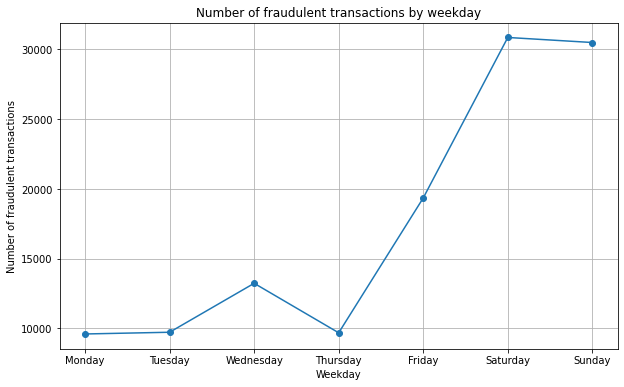

In [14]:
import calendar
plt.figure(figsize = (10,6))
frauds_count = df_transactions["TX_FRAUD"].groupby(df_transactions["TX_WEEKDAY"]).count()
plt.plot(frauds_count.index, frauds_count.values, marker='o')
plt.title('Number of fraudulent transactions by weekday')
plt.xlabel('Weekday')
plt.ylabel('Number of fraudulent transactions')
plt.xticks(ticks=range(7), labels=[calendar.day_name[i] for i in range(7)])
plt.grid(True)
plt.show()

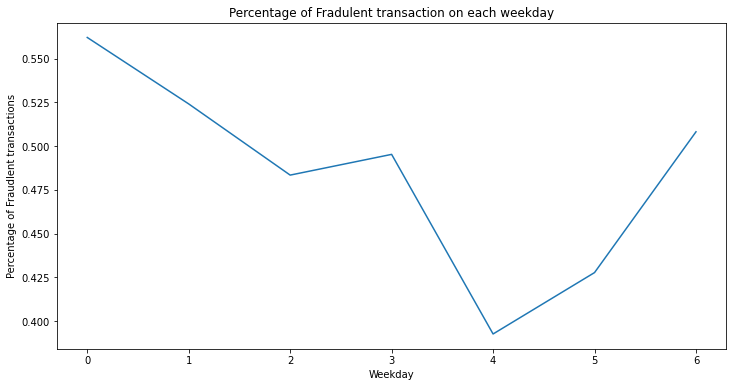

In [18]:
df_fraud_counts = df_transactions.groupby(["TX_WEEKDAY"])["TX_FRAUD"].sum().to_frame()
df_day_counts = df_transactions.groupby(["TX_WEEKDAY"]).count()["TX_AMOUNT"].to_frame()
df_day_counts

df_counts = pd.merge(df_day_counts, df_fraud_counts, how="inner", left_index=True, right_index=True)
df_counts["fraud_ratio"] = 100*df_counts["TX_FRAUD"]/df_counts["TX_AMOUNT"]

plt.figure(figsize=(12,6))
sns.lineplot(x="TX_WEEKDAY", y="fraud_ratio", data=df_counts);
plt.xlabel("Weekday")
plt.ylabel("Percentage of Fraudlent transactions")
plt.title("Percentage of Fradulent transaction on each weekday");

Conclusion: Monday has the highest ratio of fraudulent transactions

In [19]:
# measure the Risk of a terminal over a day
grouped_cols = ["TERMINAL_ID", "TX_DATE"]
terminal_stats = df_transactions.groupby(grouped_cols).agg(
    total_transactions=("TX_FRAUD", "count"),
    fraudulent_transactions=("TX_FRAUD", "sum")
).reset_index()

terminal_stats['daily_risk'] = terminal_stats['fraudulent_transactions'] / terminal_stats['total_transactions']
terminal_stats['TERMINAL_RISK_1D'] = terminal_stats.groupby(['TERMINAL_ID'])['daily_risk'].shift()
df_transactions = pd.merge(df_transactions, terminal_stats[['TERMINAL_ID', 'TX_DATE', 'TERMINAL_RISK_1D']],
                           on=['TERMINAL_ID', 'TX_DATE'], 
                           how='left')
df_transactions.sort_values(by= "TX_DATETIME").head()

,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD,TX_DATE,TX_WEEKDAY,TX_WEEK,TERMINAL_RISK_1D
3988,2024-03-01 00:00:35,1866,5557,90.53,0,2024-03-01,4,9,NaN
25572,2024-03-01 00:00:58,286,2776,84.85,0,2024-03-01,4,9,NaN
12314,2024-03-01 00:01:59,4475,4716,125.81,0,2024-03-01,4,9,NaN
26980,2024-03-01 00:02:22,950,6093,155.13,0,2024-03-01,4,9,NaN
9594,2024-03-01 00:04:48,2384,4039,148.01,0,2024-03-01,4,9,NaN


1. SPENT_1D: The median dollar value of transactions for this customer on previous day
2. SPENT_1W: The median dollar value of transactions for this customer on previous week

In [20]:
df_transactions['TX_DATE'] = pd.to_datetime(df_transactions['TX_DATE'])

daily_median = df_transactions.groupby(['CUSTOMER_ID', 'TX_DATE'])['TX_AMOUNT'].median().reset_index()
daily_median.rename(columns={'TX_AMOUNT': 'SPENT_1D'}, inplace=True)
daily_median['SPENT_1D'] = daily_median.groupby('CUSTOMER_ID')['SPENT_1D'].shift()
df_transactions = pd.merge(df_transactions, daily_median[['CUSTOMER_ID', 'TX_DATE', 'SPENT_1D']], 
                           on=['CUSTOMER_ID', 'TX_DATE'], 
                           how='left')

weekly_median = df_transactions.groupby(['CUSTOMER_ID', 'TX_WEEK'])['TX_AMOUNT'].median().reset_index()
weekly_median.rename(columns={'TX_AMOUNT': 'SPENT_1W'}, inplace=True)
weekly_median['SPENT_1W'] = weekly_median.groupby('CUSTOMER_ID')['SPENT_1W'].shift()
df_transactions = pd.merge(df_transactions, weekly_median[['CUSTOMER_ID', 'TX_WEEK', 'SPENT_1W']], 
                           on=['CUSTOMER_ID', 'TX_WEEK'], 
                           how='left')
df_transactions.sort_values(by= "TX_DATETIME").head()

,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD,TX_DATE,TX_WEEKDAY,TX_WEEK,TERMINAL_RISK_1D,SPENT_1D,SPENT_1W
3988,2024-03-01 00:00:35,1866,5557,90.53,0,2024-03-01,4,9,NaN,NaN,NaN
25572,2024-03-01 00:00:58,286,2776,84.85,0,2024-03-01,4,9,NaN,NaN,NaN
12314,2024-03-01 00:01:59,4475,4716,125.81,0,2024-03-01,4,9,NaN,NaN,NaN
26980,2024-03-01 00:02:22,950,6093,155.13,0,2024-03-01,4,9,NaN,NaN,NaN
9594,2024-03-01 00:04:48,2384,4039,148.01,0,2024-03-01,4,9,NaN,NaN,NaN


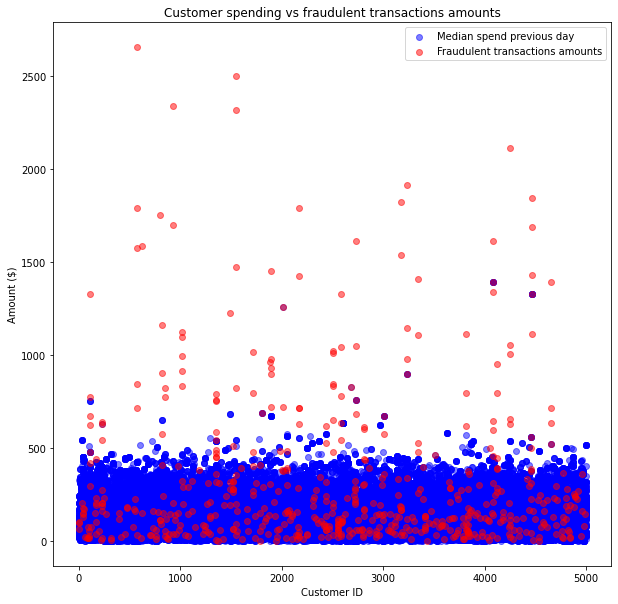

In [21]:
fraud_transactions = df_transactions[df_transactions['TX_FRAUD'] == 1]

plt.figure(figsize=(10, 10))
# Median amount spent by customer on the previous day (SPENT_1D)
plt.scatter(df_transactions['CUSTOMER_ID'].values, df_transactions['SPENT_1D'], 
            color='blue', alpha=0.5, label='Median spend previous day')

# Fraudulent transaction amounts
plt.scatter(fraud_transactions['CUSTOMER_ID'].values, fraud_transactions['TX_AMOUNT'], 
            color='red', alpha=0.5, label='Fraudulent transactions amounts')

plt.title('Customer spending vs fraudulent transactions amounts')
plt.xlabel('Customer ID')
plt.ylabel('Amount ($)')
plt.legend()
plt.show()

Based on the scatter plot, the median spend of customers on the previous day seems to be concentrated mainly in the lower range, with a dense clustering of points near the bottom of the plot. The amounts for fraudulent transactions are dispersed at higher values and do not show a strong overlap with the median spending. This visualization suggests that the amount spent in fraudulent transactions tends to be higher compared to the median daily spending of customers, indicating that there might be a distinct pattern where higher spending could be associated with fraud. This means adding this feature to the model will likely improve the performance of the model

In [22]:
df_card_data = pd.read_csv("./card_data.csv", index_col="TRANSACTION_ID", parse_dates=["TX_DATETIME"])
df_card_data.head()

,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD,IS_WEEKEND,IS_WEDNESDAY,IS_NIGHT,TX_HOUR,TX_DATE,...,CUSTOMER_RISK_1D,TX_WEEK,TERMINAL_TOTAL_1W,TERMINAL_FRAUD_1W,TERMINAL_RISK_1W,CUSTOMER_TOTAL_1W,CUSTOMER_FRAUD_1W,CUSTOMER_RISK_1W,SPENT_1D,SPENT_1W
TRANSACTION_ID,,,,,,,,,,,,,,,,,,,,,
1081139,2024-04-01 00:02:24,363,7797,254.71,0,0,0,1,0,2024-04-01,...,0.0,14,5.0,0.0,0.0,16.0,0.0,0.0,275.366667,189.17
1084811,2024-04-01 10:19:01,363,9851,176.84,0,0,0,0,10,2024-04-01,...,0.0,14,2.0,0.0,0.0,16.0,0.0,0.0,275.366667,189.17
1085737,2024-04-01 11:37:14,363,7701,130.33,0,0,0,0,11,2024-04-01,...,0.0,14,7.0,0.0,0.0,16.0,0.0,0.0,275.366667,189.17
1149170,2024-04-07 01:00:02,363,6059,188.83,0,1,0,1,1,2024-04-07,...,0.0,14,6.0,0.0,0.0,16.0,0.0,0.0,380.720000,189.17
1152136,2024-04-07 07:37:41,363,769,178.29,0,1,0,0,7,2024-04-07,...,0.0,14,2.0,0.0,0.0,16.0,0.0,0.0,380.720000,189.17


**LOGISTIC MODEL**

In [31]:
df_card_data["TX_DATE"] = pd.to_datetime(df_card_data["TX_DATE"] )
df_card_train = df_card_data.loc[df_card_data['TX_DATE'] <= pd.to_datetime("2024-04-09")]
df_card_test = df_card_data.loc[df_card_data['TX_DATE'] == pd.to_datetime("2024-04-10")]

df_card_train = sm.add_constant(df_card_train)
features = ['TX_AMOUNT','IS_WEEKEND', 'IS_WEDNESDAY', 'IS_NIGHT', 'TX_HOUR',
       'TERMINAL_TOTAL_1D', 'TERMINAL_FRAUD_1D', 'TERMINAL_RISK_1D',
       'CUSTOMER_TOTAL_1D', 'CUSTOMER_FRAUD_1D', 'CUSTOMER_RISK_1D',
       'TERMINAL_TOTAL_1W', 'TERMINAL_FRAUD_1W', 'TERMINAL_RISK_1W',
       'CUSTOMER_TOTAL_1W', 'CUSTOMER_FRAUD_1W', 'CUSTOMER_RISK_1W',
       'SPENT_1D', 'SPENT_1W', 'const']
predict = "TX_FRAUD"

x = df_card_train[features]
y = df_card_train[predict]

df_card_test['const'] = 1.0
logit_2 = sm.Logit(y,x).fit()
logit_2_probs = logit_2.predict(df_card_test[features]) 
logit_2_auc = roc_auc_score(df_card_test[predict], logit_2_probs)
print(round(logit_2_auc,3))
logit_2.summary()

Optimization terminated successfully.
         Current function value: 0.014607
         Iterations 11
0.797


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               TX_FRAUD   No. Observations:               102658
Model:                          Logit   Df Residuals:                   102638
Method:                           MLE   Df Model:                           19
Date:                Wed, 05 Mar 2025   Pseudo R-squ.:                  0.4696
Time:                        17:41:27   Log-Likelihood:                -1499.5
converged:                       True   LL-Null:                       -2827.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
TX_AMOUNT             0.0138      0.001     23.183      0.000       0.013       0.015
IS_WEEKEND           -0.6381      0.153     -4.184      0.000      -0.937      -0.339
IS_WEDNESDAY          0.2321      0.181      1.282      0.200      -0.123       0.587
IS_NIGHT              0.0470      0.255      0.185      0.853      -0.452       0.546
TX_HOUR               0.0023      0.015      0.159      0.874      -0.026       0.031
TERMINAL_TOTAL_1D    -0.0186      0.072     -0.258      0.797      -0.160       0.123
TERMINAL_FRAUD_1D     1.6771      0.231      7.250      0.000       1.224       2.130
TERMINAL_RISK_1D      4.0067      0.363     11.053      0.000       3.296       4.717
CUSTOMER_TOTAL_1D     0.0065      0.029      0.226      0.821      -0.050       0.063
CUSTOMER_FRAUD_1D     1.0138      0.177      5.718      0.000       0.666       1.361
CUSTOMER_RISK_1D      1.8151      0.631      2.878      0.004       0.579       3.051
TERMINAL_TOTAL_1W     0.0041      0.018      0.227      0.820      -0.031       0.040
TERMINAL_FRAUD_1W     0.2079      0.108      1.918      0.055      -0.004       0.420
TERMINAL_RISK_1W     -0.4003      0.845     -0.474      0.636      -2.057       1.256
CUSTOMER_TOTAL_1W     0.0027      0.007      0.405      0.686      -0.010       0.016
CUSTOMER_FRAUD_1W     0.3943      0.089      4.443      0.000       0.220       0.568
CUSTOMER_RISK_1W      2.4267      2.008      1.208      0.227      -1.509       6.363
SPENT_1D              0.0006      0.001      0.622      0.534      -0.001       0.003
SPENT_1W             -0.0191      0.002    -12.088      0.000      -0.022      -0.016
const                -6.3243      0.331    -19.106      0.000      -6.973      -5.676
=====================================================================================
"""

The significant features reflect properties of the underlying data generating process. Possible reasons:
- TX_AMOUNT: Fraudulent transactions seem to be of higher value than genuine transactions
- TERMINAL_FRAUD_1D, TERMINAL_RISK_1D: If a terminal is compromised then significant number of transactions are fraudulent. Since the lagged week features are not all significant, it implies that compromised terminals are identified quickly (i.e., in days).
- CUSTOMER_FRAUD_1D/CUSTOMER_FRAUD_1W: Total number of fraudulent transactions are relevant for customers as one would expect a non-compromised card to have zero fraudulent transactions. 
- SPENT_1D/SPENT_1W: The fraudulent transactions are higher than the average spend of the customer. It is expected that the fraudulent transactions may be different from the average spent as a customer's average spend is generally private information.

**NEURAL NETWORKS MODELS**

In [25]:
def build_nn_model(input_features, output_feature, num_layers, num_units, data, split_date):
    clear_session()  
    train_data = data[data["TX_DATE"] < pd.to_datetime(split_date)]
    test_data = data[data["TX_DATE"] >= pd.to_datetime(split_date)]
    
    X_train = train_data[input_features]
    y_train = train_data[output_feature]
    X_test = test_data[input_features]
    y_test = test_data[output_feature]

    input_shape = X_train.shape[1:]
    input_layer = Input(shape=input_shape, name="input_layer")
    op = input_layer
    for i in range(1, num_layers + 1):
        op = Dense(units=num_units, activation="relu", name=f"hidden_layer_{i}")(op)
    output_layer = Dense(units=1, activation="sigmoid", name="output_layer")(op)
    
    nn = Model(inputs=input_layer, outputs=output_layer)
    nn.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    
    # Set training parameters
    epochs = 1000
    patience = 2
    verbose = 2
    batch_size = X_train.shape[0]

    # Define the early stopping callback
    callbacks = [EarlyStopping(monitor='val_loss', patience=patience)]

    # Train and validate the model
    nn.fit(X_train, y_train,
           epochs=epochs,
           callbacks=callbacks,
           validation_data=(X_test, y_test),
           batch_size=batch_size,
           verbose=verbose)
    
    # Compute AUC for train and test sets
    train_auc = roc_auc_score(y_train, nn.predict(X_train).ravel())
    test_auc = roc_auc_score(y_test, nn.predict(X_test).ravel())
    return nn, train_auc, test_auc

In [29]:
input_features = ['TX_AMOUNT','IS_WEEKEND', 'IS_WEDNESDAY', 'IS_NIGHT', 'TX_HOUR',
       'TERMINAL_TOTAL_1D', 'TERMINAL_FRAUD_1D', 'TERMINAL_RISK_1D',
       'CUSTOMER_TOTAL_1D', 'CUSTOMER_FRAUD_1D', 'CUSTOMER_RISK_1D', 'TX_WEEK',
       'TERMINAL_TOTAL_1W', 'TERMINAL_FRAUD_1W', 'TERMINAL_RISK_1W',
       'CUSTOMER_TOTAL_1W', 'CUSTOMER_FRAUD_1W', 'CUSTOMER_RISK_1W',
       'SPENT_1D', 'SPENT_1W']
output_feature = "TX_FRAUD"
nn_3 = build_nn_model(input_features=input_features, output_feature=output_feature, num_layers=4, num_units=16, 
                      data=df_card_data, split_date="2024-04-03")
nn_4 = build_nn_model(input_features=input_features, output_feature=output_feature, num_layers=4, num_units=16, 
                      data=df_card_data, split_date="2024-04-09")

Epoch 1/1000
1/1 - 1s - loss: 15.4626 - accuracy: 0.0045 - val_loss: 12.4011 - val_accuracy: 0.0058 - 624ms/epoch - 624ms/step
Epoch 2/1000
1/1 - 0s - loss: 12.4957 - accuracy: 0.0051 - val_loss: 9.2938 - val_accuracy: 0.0085 - 41ms/epoch - 41ms/step
Epoch 3/1000
1/1 - 0s - loss: 9.5239 - accuracy: 0.0073 - val_loss: 6.2111 - val_accuracy: 0.0246 - 29ms/epoch - 29ms/step
Epoch 4/1000
1/1 - 0s - loss: 6.5584 - accuracy: 0.0171 - val_loss: 3.4541 - val_accuracy: 0.1489 - 30ms/epoch - 30ms/step
Epoch 5/1000
1/1 - 0s - loss: 3.7724 - accuracy: 0.1019 - val_loss: 1.5598 - val_accuracy: 0.3998 - 31ms/epoch - 31ms/step
Epoch 6/1000
1/1 - 0s - loss: 1.7383 - accuracy: 0.3464 - val_loss: 0.5936 - val_accuracy: 0.6924 - 29ms/epoch - 29ms/step
Epoch 7/1000
1/1 - 0s - loss: 0.6591 - accuracy: 0.6470 - val_loss: 0.2900 - val_accuracy: 0.8875 - 40ms/epoch - 40ms/step
Epoch 8/1000
1/1 - 0s - loss: 0.3029 - accuracy: 0.8730 - val_loss: 0.2026 - val_accuracy: 0.9419 - 40ms/epoch - 40ms/step
Epoch 9/100

In [30]:
print(f"{nn_3[1]} \n{nn_3[2]}") 
print(f"{nn_4[1]} \n{nn_4[2]}") 

0.3661678189603982 
0.3723007413275273
0.856542428473956 
0.810073459510846


This suggests that nn4 is better at distinguishing between fraudulent and non-fraudulent transactions in this dataset 